Below is a **self-contained implementation** with:

* k-NN graph construction
* All-pairs shortest paths (Dijkstra on the graph)
* Classical MDS on the geodesic distances
* A small demo using a Swiss roll.

In [17]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
import numpy as np
from heapq import heappush, heappop
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plots

from sklearn.manifold import Isomap
from sklearn.neighbors import NearestNeighbors

---

## Core Isomap Implementation (from scratch)

In [9]:
def pairwise_distances(X):
    """
    Compute full pairwise Euclidean distance matrix for X.
    X: (n_samples, n_features)
    Returns: (n_samples, n_samples)
    """
    # Efficient vectorized squared distances
    X = np.asarray(X)
    sq_norms = np.sum(X ** 2, axis=1, keepdims=True)  # (n, 1)
    sq_dists = sq_norms + sq_norms.T - 2 * X @ X.T
    sq_dists = np.maximum(sq_dists, 0.0)  # avoid negatives from numerical error
    return np.sqrt(sq_dists)


def build_knn_graph(D, n_neighbors):
    """
    Build a symmetric k-NN graph from distance matrix D.
    D: (n, n) pairwise distance matrix.
    n_neighbors: number of neighbors (k).
    Returns: adjacency matrix (n, n) with np.inf for no edge.
    """
    n = D.shape[0]
    # Initialize adjacency with infinity
    G = np.full_like(D, np.inf, dtype=float)

    for i in range(n):
        # argsort distances for point i (smallest first, including self)
        neigh_idx = np.argsort(D[i])[: n_neighbors + 1]  # +1 because self is included
        for j in neigh_idx:
            if i == j:
                continue
            G[i, j] = D[i, j]
            G[j, i] = D[i, j]  # make it symmetric

    return G


def dijkstra_all_pairs(G):
    """
    Compute all-pairs shortest path distances using Dijkstra
    on a dense adjacency matrix G with np.inf for missing edges.

    G: (n, n) adjacency matrix.
    Returns: dist_matrix (n, n)
    """

    # Number of nodes in the graph (G is an n×n adjacency matrix)
    n = G.shape[0]

    # Initialize an n×n matrix to store shortest-path distances
    # dist_all[src][v] will be the shortest distance from src to v
    dist_all = np.zeros((n, n), dtype=float)

    # Run Dijkstra for every possible source node
    for src in range(n):

        # Initialize all distances from src as infinite
        dist = np.full(n, np.inf, dtype=float)

        # Distance from src to itself is zero
        dist[src] = 0.0

        # Track which nodes have been permanently visited
        visited = np.zeros(n, dtype=bool)

        # Priority queue (min-heap) storing (distance, node)
        heap = [(0.0, src)]

        # Main Dijkstra loop: process nodes in increasing distance order
        while heap:
            # Extract the node with the smallest tentative distance
            d_u, u = heappop(heap)

            # If we've already processed this node, skip it
            if visited[u]:
                continue

            # Mark this node as visited (its shortest path is now known)
            visited[u] = True

            # Relax edges: check neighbors v of u
            for v in range(n):
                # Edge weight from u to v
                w = G[u, v]

                # Skip if no edge exists (represented by np.inf)
                if w == np.inf:
                    continue

                # Compute new possible distance to v via u
                alt = d_u + w

                # If this new path is shorter, update it
                if alt < dist[v]:
                    dist[v] = alt

                    # Push the updated distance into the priority queue
                    heappush(heap, (alt, v))

        # Store the completed shortest-path distances from src to all nodes
        dist_all[src] = dist

    # Return the full all-pairs shortest-path matrix
    return dist_all



def classical_mds(D, n_components=2):
    """
    Classical MDS on a distance matrix D.
    D: (n, n) distance matrix.
    Returns: Y (n, n_components) low-dimensional embedding.
    """

    # Number of samples
    n = D.shape[0]

    # Square the distances (MDS uses squared distances in its derivation)
    D2 = D ** 2

    # Construct the centering matrix H = I - (1/n) * 11ᵀ
    # This matrix removes the mean from each row and column when applied.
    H = np.eye(n) - np.ones((n, n)) / n

    # Compute the double-centered Gram matrix:
    # B = -1/2 * H * D² * H
    # This converts squared distances into an inner-product (kernel) matrix.
    B = -0.5 * H @ D2 @ H

    # Perform eigen-decomposition on B (which is symmetric)
    # eigvals: eigenvalues, eigvecs: corresponding eigenvectors
    eigvals, eigvecs = np.linalg.eigh(B)

    # Sort eigenvalues (and eigenvectors) in descending order
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Keep only the first n_components *positive* eigenvalues
    # Negative eigenvalues arise from noise or non-Euclidean distances.
    eigvals_clipped = np.maximum(eigvals[:n_components], 0)

    # Build diagonal matrix of sqrt eigenvalues (scales embedding axes)
    L = np.diag(np.sqrt(eigvals_clipped))

    # Select the top n_components eigenvectors
    V = eigvecs[:, :n_components]

    # Final low-dimensional coordinates: Y = V * sqrt(Λ)
    Y = V @ L

    return Y


def residual_variance(D_geo, Y):
    """
    Compute residual variance between geodesic distances D_geo
    and distances in the embedding Y.

    Returns: scalar residual variance in [0, 1].
    """

    # Ensure D_geo is a NumPy array (in case it's a list or other format)
    D_geo = np.asarray(D_geo)

    # Compute Euclidean pairwise distances between all points in the embedding Y
    D_Y = pairwise_distances(Y)

    # Number of points
    n = D_geo.shape[0]

    # Get indices of the upper triangular part of the matrix (k=1 excludes diagonal)
    # This avoids computing duplicate distances and self-distances
    iu = np.triu_indices(n, k=1)

    # Extract the geodesic distances for all unique pairs
    d1 = D_geo[iu]

    # Extract the corresponding Euclidean distances in the embedding space
    d2 = D_Y[iu]

    # Remove pairs where either geodesic or embedding distance is infinite
    # (can happen in disconnected graphs)
    mask = np.isfinite(d1) & np.isfinite(d2)
    d1 = d1[mask]
    d2 = d2[mask]

    # Compute means of the finite distances
    d1_mean = d1.mean()
    d2_mean = d2.mean()

    # Numerator of the Pearson correlation: covariance of (d1, d2)
    num = np.sum((d1 - d1_mean) * (d2 - d2_mean))

    # Denominator: product of standard deviations
    den = np.sqrt(np.sum((d1 - d1_mean) ** 2) * np.sum((d2 - d2_mean) ** 2))

    # If denominator is zero, correlation is undefined → treat as 0 correlation
    if den == 0:
        R = 0.0
    else:
        # Pearson correlation coefficient between geodesic distances and embedding distances
        R = num / den

    # Residual variance is 1 − R², a measure of how much variance is *not* explained
    return 1.0 - R**2


In [10]:
class IsomapScratch:
    """
    Simple Isomap implementation from scratch.

    Methods:
      - fit(X): compute embedding
      - fit_transform(X): fit and return embedding
    """

    def __init__(self, n_neighbors=10, n_components=2):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.embedding_ = None
        self.geodesic_distances_ = None
        self.residual_variance_ = None

    def fit(self, X):
        X = np.asarray(X)
        # 1) Pairwise Euclidean distances
        D = pairwise_distances(X)

        # 2) k-NN graph
        G = build_knn_graph(D, n_neighbors=self.n_neighbors)

        # 3) All-pairs shortest paths ~ geodesic distances
        D_geo = dijkstra_all_pairs(G)
        self.geodesic_distances_ = D_geo

        # 4) Classical MDS on geodesic distances
        Y = classical_mds(D_geo, n_components=self.n_components)
        self.embedding_ = Y

        # 5) Residual variance
        self.residual_variance_ = residual_variance(D_geo, Y)
        
        return self

    def fit_transform(self, X):
        self.fit(X)
        return self.embedding_

---

## 🌀 Demo: Swiss Roll Example

In [11]:
# Generate Swiss roll
X, t = make_swiss_roll(n_samples=1000, noise=0.05)
# X = X[:, [0: 2]]  # (x, z) only or keep all 3 dims

In [12]:
# Run Isomap
iso = IsomapScratch(n_neighbors=10, n_components=2)
Y = iso.fit_transform(X)

In [13]:
print("Residual variance:", iso.residual_variance_)

Residual variance: 0.00045397122562362835


In [14]:
# --- Build k-NN graph for visualization ---
n_neighbors = 10

# Uses your earlier functions
D = pairwise_distances(X)
G = build_knn_graph(D, n_neighbors=n_neighbors)

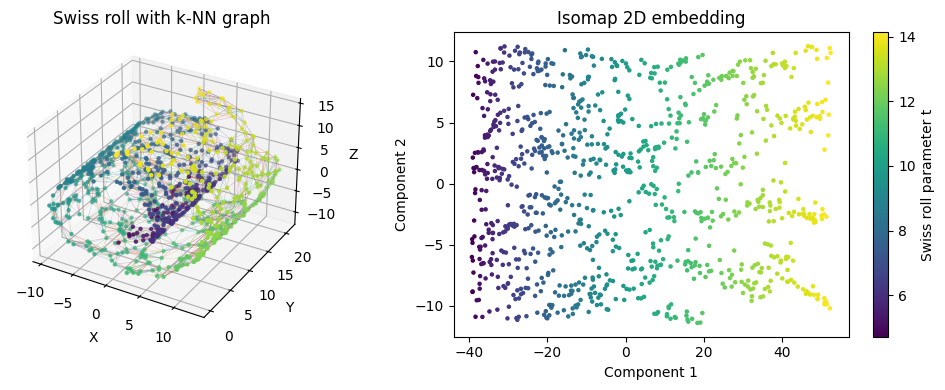

In [16]:
fig = plt.figure(figsize=(16, 4))

# (a) 3D Swiss roll with k-NN graph
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, s=5)

# Draw k-NN graph edges
rows, cols = np.where(np.isfinite(G))
for i, j in zip(rows, cols):
    if i < j:  # avoid double-plotting edges
        xs = [X[i, 0], X[j, 0]]
        ys = [X[i, 1], X[j, 1]]
        zs = [X[i, 2], X[j, 2]]
        ax1.plot(xs, ys, zs, linewidth=0.3, alpha=0.4)

ax1.set_title("Swiss roll with k-NN graph")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")

# (b) 2D Isomap embedding
ax2 = fig.add_subplot(1, 3, 2)
sc = ax2.scatter(Y[:, 0], Y[:, 1], c=t, s=5)
ax2.set_title("Isomap 2D embedding")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")
plt.colorbar(sc, ax=ax2, label="Swiss roll parameter t")

plt.tight_layout()
plt.show()

# Using sklearn for Isomap

In [18]:
# -------------------------------
# 1. Generate Swiss roll dataset
# -------------------------------
n_samples = 1000
X_3d, t = make_swiss_roll(n_samples=n_samples, noise=0.05)
X = X_3d  # shape: (n_samples, 3)

# -------------------------------
# 2. Build k-NN graph (sklearn)
# -------------------------------
n_neighbors = 10

nbrs = NearestNeighbors(n_neighbors=n_neighbors)
nbrs.fit(X)
distances, indices = nbrs.kneighbors(X)  # indices: (n_samples, n_neighbors)

In [19]:
# -------------------------------
# 3. Run Isomap for 2D embedding
# -------------------------------
iso_2d = Isomap(n_neighbors=n_neighbors, n_components=2)
Y_2d = iso_2d.fit_transform(X)  # shape: (n_samples, 2)

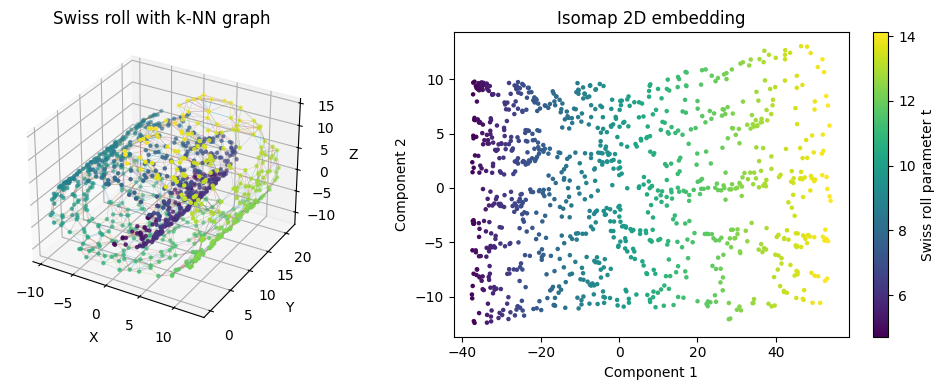

In [21]:
# -------------------------------
# 5. Plotting
# -------------------------------
fig = plt.figure(figsize=(16, 4))

# (a) 3D Swiss roll with k-NN graph
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
# Scatter points
p = ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, s=5)

# Draw k-NN edges
n = X.shape[0]
for i in range(n):
    for j in indices[i]:
        if i < j:  # avoid drawing each edge twice
            xs = [X[i, 0], X[j, 0]]
            ys = [X[i, 1], X[j, 1]]
            zs = [X[i, 2], X[j, 2]]
            ax1.plot(xs, ys, zs, linewidth=0.3, alpha=0.4)

ax1.set_title("Swiss roll with k-NN graph")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")

# (b) 2D Isomap embedding
ax2 = fig.add_subplot(1, 3, 2)
sc = ax2.scatter(Y_2d[:, 0], Y_2d[:, 1], c=t, s=5)
ax2.set_title("Isomap 2D embedding")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")
plt.colorbar(sc, ax=ax2, label="Swiss roll parameter t")

plt.tight_layout()
plt.show()

- Same math, same algorithmic idea.

- Your version: pure Python, dense graph, O(n³) Dijkstra, interpreted loops → slow.

- sklearn: sparse graph, compiled shortest-path solver, optimized linear algebra → fast.